In [1]:
import os, sys
import general_config 
print(general_config.ROOTDIR)
sys.path.append(general_config.ROOTDIR)

import numpy as np
import matplotlib.pyplot as plt

D:/Desktop@D/xai_basic


# Main objective
Recall that, ultimately, the objective of this project is to provide users with a dataset containing images with ground-truth heatmaps. <b>Why?</b> As indicated with the paper published along with this project, many heatmap-based XAI methods do not have reliable ways to show that their heatmaps are correct. We want to solve this problem. <br><br>
As you have seen, the solution so far is to provide ground-truth heatmap for each image. The heatmap must tell us which parts of the image are the features that unambiguously distinguish the class to which the image belong. <br><br>

This tutorial is the simplified version of the evaluation we actually performed using <b>aggregate_evaluation()</b> in pipeline.eval.evaluation_xai_implementation.py.

# Loading trained model
Assume we have trained a model and validated it. The next step is to check how good its prediction is, and study the heatmaps generated using different methods when applied to the model. Here, we provide one of our pre-trained models (scoring >0.95 in accuracy on 1600 test samples) for testing.<br>

In [2]:
from _tutorials.tutorial_utils import download_file_from_google_drive
file_id = '1g4bcxIArx6uNIrXDK69FhIrGe1lpQOB1'
MODEL_DIR = 'temp/demo.model.optim' # save to this directory
if not os.path.exists(MODEL_DIR):
    download_file_from_google_drive(file_id, MODEL_DIR)
    print('pre-trained model downloaded.')
else:
    print('pre-trained model exists.')

pre-trained model exists.


Once we finish downloading the model, let us set it up.

In [3]:
import torch
from model.adjusted_resnet34 import AdjResnet34

this_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
net = AdjResnet34()
net.load_state_dict(torch.load(MODEL_DIR)) 
net.readjust()
net.to(this_device)
net.eval() #VERY IMPT. Without this, some randomness used for training phase will ruin the prediction.
print('loaded')

loaded


# XAI Methods: Heatmap generators
There are many methods available in Captum pytorch (see https://captum.ai/api/). We test <b>Saliency</b> here, though many others are applied in a similar way in our actual experiment.

In [4]:
from captum.attr import Saliency
attrmodel = Saliency(net)

# How to quantify heatmaps?
Quantifying heatmaps could be difficult. One reason is how "correct" a heatmap is can be dependent on the context. Another reason is, heatmap generators effectively create an array of values. Sometimes these numbers are not clearly assigned consistent meaning. For example, when the value in a pixel is negative, does it mean that this pixel really contribute <i>against</i> certain prediction? What does "contribute against" even mean, in rigorous terms? <br><br>
We design 5-band metric that assigns each pixel either 2,1,0,-1,-2, in a process we naturally call <b>stratification</b>. Following the convention we have so far, we set 2 to denote discriminative feature, 1 to localization, 0 to irrelevant pixels, -1 negative contribution, -2 highly negative contribution. The paper in our result compares the performance of XAI methods based on this metric. This metric may not be the best, and the way we use soft-thresholding may be flawed as well. Undoubtedly, there are still many definitions and concepts to be cleared up.

In [5]:
XAI_SETTING_0001 = {
    'xai_channel_transformation': 'sum_pixels_over_channels',
    'sum_pixels_over_channels': {
        'normalize': 'absmax_after_sum'
    },
    'five_band_stratification':{
        'thresholds': np.array([-0.5, -0.3, 0.3, 0.5]),
        'targets': np.array([-2,-1,0,1,2]),                     
    },
    'five_band_stratification_for_groundtruth':{
        'thresholds': np.array([-0.7, -0.3, 0.3, 0.7]),
        'targets': np.array([-2,-1,0,1,2]),  
    },
    'soft_delta':0.005,
    'n_soft_steps':56,
}

In [6]:
from pipeline.eval.eval_metrics import FiveBandXAIMetric
xai = FiveBandXAIMetric()

# Evaluation the Accuracy and Quantifying Heatmaps
In tutorial_002, we have prepared 2 chunks (shards) for testing, each containing 24 samples. <br>
$\rightarrow$ total testing samples: 48 <br><br>
The following are the steps to process each sample data:
<ol>
    <li> <b>Prediction.</b> Use trained model to classify the sample image drawn from the test dataset.
    <li> <b>Heatmaps.</b> Compute the heatmaps using Captum API.
    <li> <b>Class prediction accuracy.</b> Check if the prediction is correct. Count the number of correct predictions.
    <li> <b>Quantifying heatmaps.</b> Use FiveBandXAIMetric to compute how accurate the generated heatmaps are compared to the ground-truth. The above thresholds are used, and quantities such as recall (R) and precision (P) at different thresholds are computed. In the main paper, these and other quantities in sample-wise <i>metrics_collection</i> are used to plot the R vs P figures and ROC curves.

</ol>

In [7]:
import pipeline.data.prepare_10classes_data as data10
from pipeline.eval.evaluation_utils import  pytorch_singleton_to_batch_reshape

In [8]:
n_shard = 2
CACHE_FOLDER_DIR = 'temp'
DATA_NAME = 'demo_test_data'

fiveband_results = {}
total_n, n_correct = 0, 0
test_shards = range(1,1+n_shard)
for k in test_shards:
    test_dataset = data10.load_dataset_from_a_shard(k, CACHE_FOLDER_DIR, DATA_NAME, 
        include_xai_variables=True, reshape_size=None)
    # print(np.array(test_dataset.x).shape, np.array(test_dataset.h).shape)
    for j in range(test_dataset.data_size):  
        # if j==3: break # just for debugging
            
        identifier = '%s_chunk%s_queue%s'%(str(DATA_NAME),str(k),str(j))
        
        ################# 1. Prediction ###############
        x = pytorch_singleton_to_batch_reshape(test_dataset.x[j],this_device=this_device) 
        y0 = test_dataset.y[j]        
        y = net(x)
        y_pred = torch.argmax(y)
        # print(x.shape, y0, y_pred.item(), h.shape)
        x1 = x.clone().detach().to(device=this_device)
        x1.requires_grad = True
        y = y.clone().cpu().detach().numpy()
        y_pred = int(y_pred.clone().cpu().detach().numpy())
        total_n+=1
        
        ################# 2. Heatmaps #################
        # groundtruth heatmap from the dataset
        h0 = test_dataset.h[j] # (512,512) without resize
        # generated heatmap
        attr = attrmodel.attribute(x1[0:0+1], target=y_pred).squeeze(0).cpu().detach().numpy() # (3,512,512)
        
        ########### 3. Class prediction accuracy ######
        # add one if the prediction made is correct
        pred_is_correct = int(y_pred)==int(y0)
        if pred_is_correct: n_correct+=1
            
        ########### 4. Quantifying heatmaps ###########
        # let us collect all the heatmap results here
        metrics_collection = xai.soft_fiveband_score(attr, h0, setting=XAI_SETTING_0001)
        fiveband_results[identifier] = {
            'metrics_collection':metrics_collection, 'x':test_dataset.x[j],
            'h0':h0, 'h':attr, 'y_pred':y_pred,'y0':y0,'pred_is_correct':pred_is_correct
        }
        
        ########### printing progress ##############
        update_text = 'shard: %2s/%2s, j:%4s/%4s, acc:%s/%s'%(str(k),str(n_shard),
            str(j+1),str(test_dataset.data_size),str(n_correct),str(total_n))
        print('%-96s'%(str(update_text)), end='\r')    
        
acc = n_correct/total_n
print('pred acc. %s/%s=%s [XAIPred Marker]'%(str(n_correct), str(total_n), str(round(acc,2))))

pred acc. 46/48=0.96 [XAIPred Marker]                                                           


In [9]:
def extract_metric_collection(i, metrics_collection):
    print('  threshold: %-32s'%(str(metrics_collection[i]['thresholds'])), end='')
    print('  R:%s, P:%s'%(round(metrics_collection[i]['recall'],4),round(metrics_collection[i]['precision'],4)))
    
def display_some_evaluation_results(metrics_collection):
    extract_metric_collection(0, metrics_collection)
    extract_metric_collection(1, metrics_collection)
    print('  ...')
    extract_metric_collection(-1, metrics_collection)

def display_heatmaps(x,h0,attr):
    plt.figure(figsize=(20,4))
    plt.gcf().add_subplot(151)
    plt.gca().imshow(x,cmap='bwr',vmin=-1, vmax=1)
    plt.gca().set_xlabel('x')
    plt.gcf().add_subplot(152)
    plt.gca().imshow(h0,cmap='bwr',vmin=-1, vmax=1)
    plt.gca().set_xlabel('h0')
    
    plt.gcf().add_subplot(153)
    plt.gca().imshow(attr[0],cmap='bwr',vmin=-1, vmax=1)
    plt.gca().set_xlabel('R')
    plt.gcf().add_subplot(154)
    plt.gca().imshow(attr[1],cmap='bwr',vmin=-1, vmax=1)
    plt.gca().set_xlabel('G')
    plt.gcf().add_subplot(155)
    plt.gca().imshow(attr[2],cmap='bwr',vmin=-1, vmax=1)
    plt.gca().set_xlabel('B')
    plt.tight_layout()
    plt.show()

# Displaying heatmaps and some quantifications
We have stored the heatmaps and some of the values used to quantify the quality of heatmaps in the previous section into <b>result_dict</b>. Let us unpack it. 

Shown here are the input image, x (left-most), the ground-truth heatmap (column 2) and the three channels (RGB) of the heatmaps generated (column 3-5). We do not show heatmaps stratified to the different threshold, but shows the metrics recall (R) and precision (P) when they are stratified to the corresponding threshold. We only show the extreme ends of the thresholds. <br><br>
y is the predicted class, y0 is the true class.

demo_test_data_chunk1_queue0 y:1, y0:1
  attr.shape:(3, 512, 512), max:0.03819206, min:4.9116267e-13
  threshold: [-0.5 -0.3  0.3  0.5]             R:0.0027, P:0.3807
  threshold: [-0.495 -0.295  0.295  0.495]     R:0.0028, P:0.3791
  ...
  threshold: [-0.225 -0.025  0.025  0.225]     R:0.2104, P:0.5526


<Figure size 432x288 with 0 Axes>

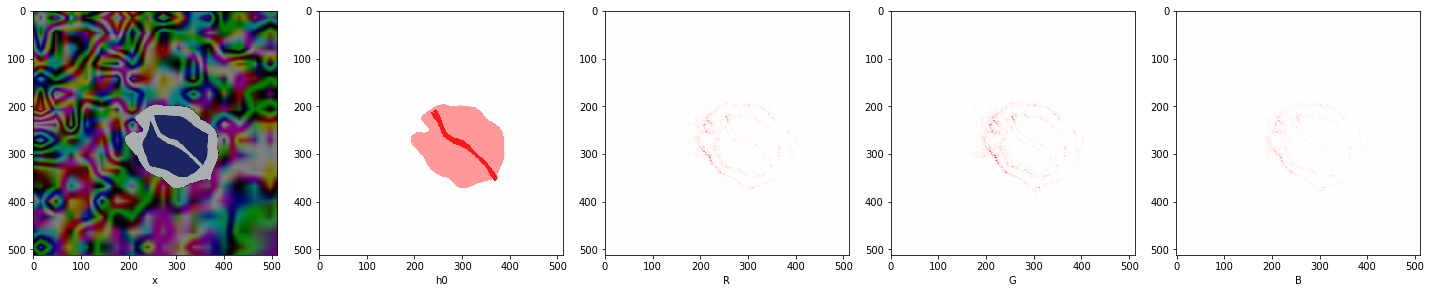

demo_test_data_chunk1_queue1 y:0, y0:0
  attr.shape:(3, 512, 512), max:0.018958371, min:1.5916157e-12
  threshold: [-0.5 -0.3  0.3  0.5]             R:0.0005, P:0.1288
  threshold: [-0.495 -0.295  0.295  0.495]     R:0.0006, P:0.1295
  ...
  threshold: [-0.225 -0.025  0.025  0.225]     R:0.0559, P:0.1717


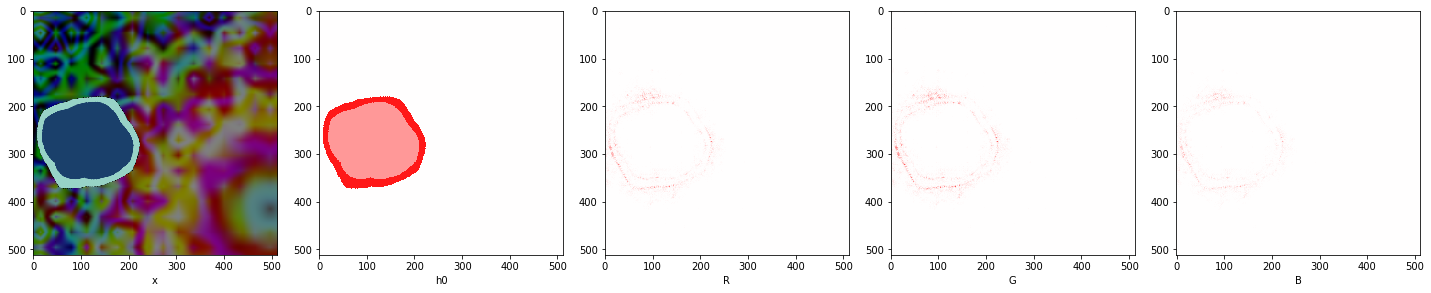

demo_test_data_chunk1_queue2 y:3, y0:3
  attr.shape:(3, 512, 512), max:0.30726996, min:7.3896445e-13
  threshold: [-0.5 -0.3  0.3  0.5]             R:0.0005, P:0.2105
  threshold: [-0.495 -0.295  0.295  0.495]     R:0.0006, P:0.2308
  ...
  threshold: [-0.225 -0.025  0.025  0.225]     R:0.0342, P:0.1885


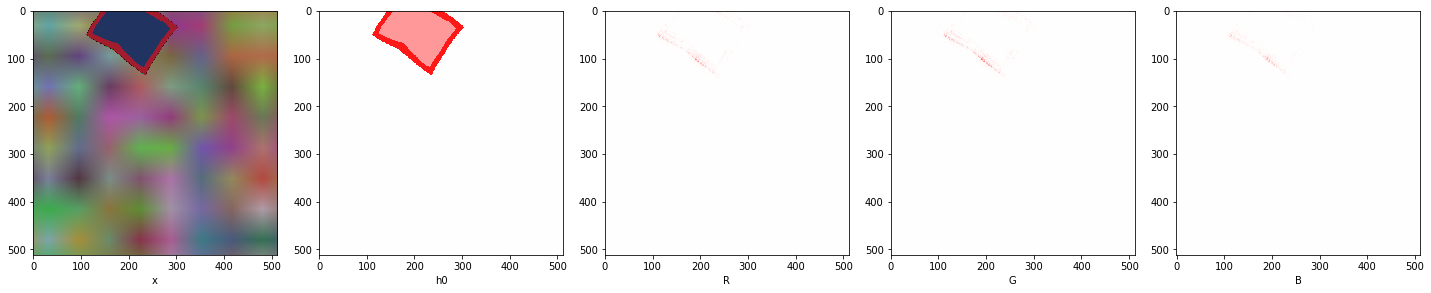

demo_test_data_chunk1_queue3 y:5, y0:5
  attr.shape:(3, 512, 512), max:0.4097403, min:0.0
  threshold: [-0.5 -0.3  0.3  0.5]             R:0.0005, P:0.1159
  threshold: [-0.495 -0.295  0.295  0.495]     R:0.0005, P:0.1039
  ...
  threshold: [-0.225 -0.025  0.025  0.225]     R:0.0028, P:0.0203


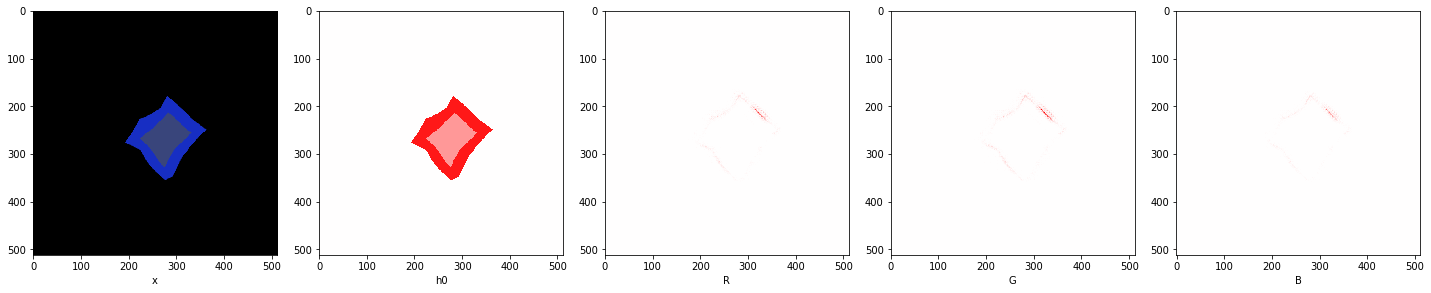

demo_test_data_chunk1_queue4 y:6, y0:7
  attr.shape:(3, 512, 512), max:0.05207916, min:0.0
  threshold: [-0.5 -0.3  0.3  0.5]             R:0.0016, P:0.3935
  threshold: [-0.495 -0.295  0.295  0.495]     R:0.0017, P:0.3975
  ...
  threshold: [-0.225 -0.025  0.025  0.225]     R:0.1121, P:0.5349


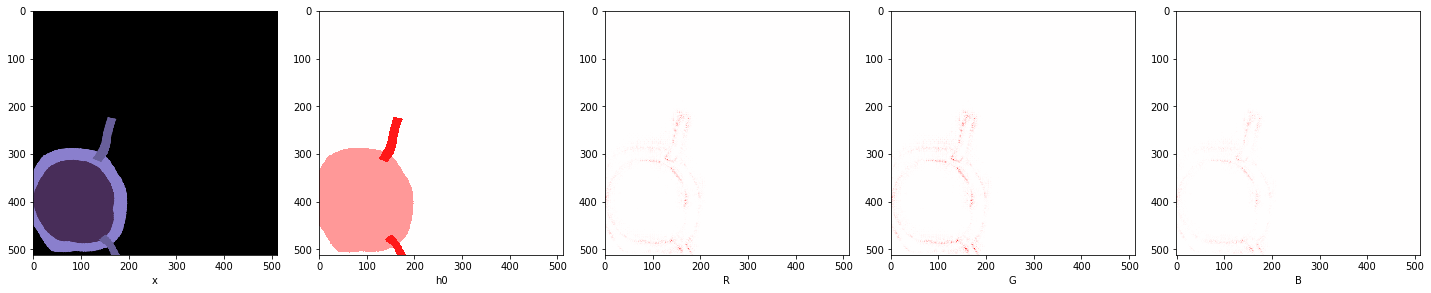

demo_test_data_chunk1_queue5 y:1, y0:1
  attr.shape:(3, 512, 512), max:0.0665329, min:7.975842e-13
  threshold: [-0.5 -0.3  0.3  0.5]             R:0.0008, P:0.3294
  threshold: [-0.495 -0.295  0.295  0.495]     R:0.0008, P:0.3295
  ...
  threshold: [-0.225 -0.025  0.025  0.225]     R:0.073, P:0.5791


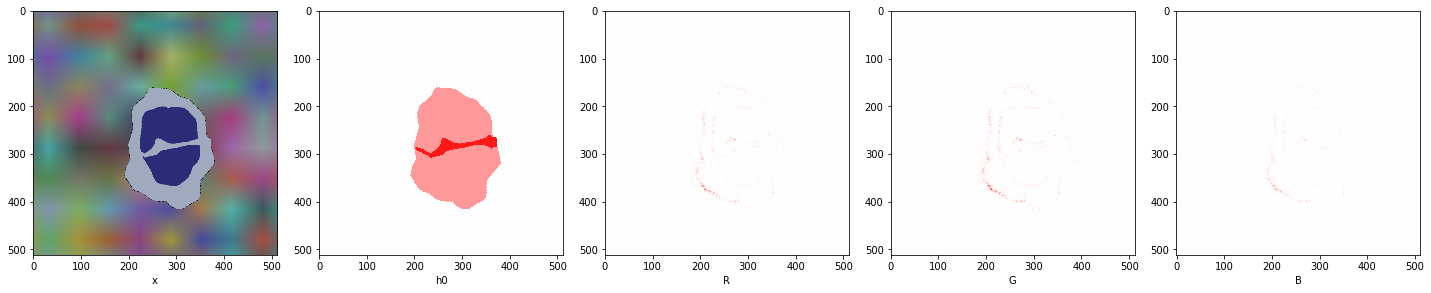

demo_test_data_chunk1_queue6 y:5, y0:5
  attr.shape:(3, 512, 512), max:0.13713326, min:4.206413e-12
  threshold: [-0.5 -0.3  0.3  0.5]             R:0.0005, P:0.1261
  threshold: [-0.495 -0.295  0.295  0.495]     R:0.0005, P:0.1217
  ...
  threshold: [-0.225 -0.025  0.025  0.225]     R:0.0055, P:0.0248


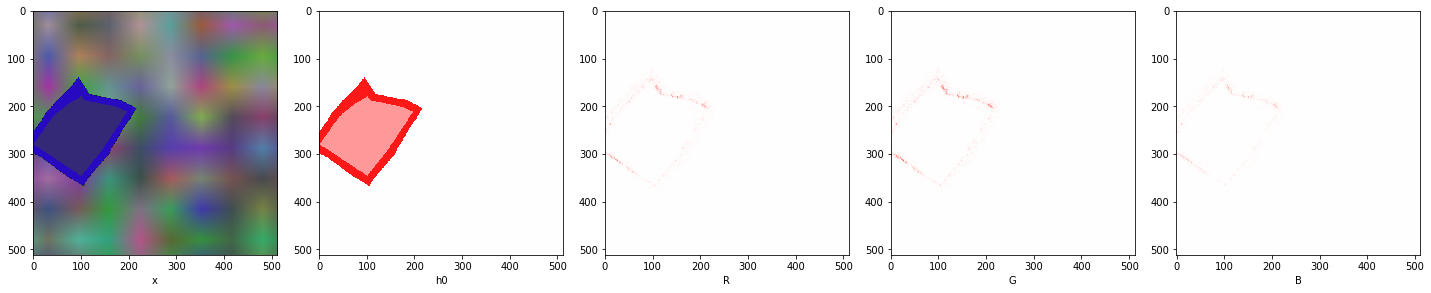

In [10]:
STOP_AT = 7

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
for i, (identifier, result_dict) in enumerate(fiveband_results.items()):
    if STOP_AT is not None:
        if i==STOP_AT: break
    
    metrics_collection = result_dict['metrics_collection']

    h0 = result_dict['h0']
    attr = result_dict['h']
    pred_is_correct = result_dict['pred_is_correct']
    
    print(identifier, 'y:%s, y0:%s'%(str(result_dict['y_pred']),str(result_dict['y0'])))
    print('  attr.shape:%s, max:%s, min:%s'%(str(attr.shape), str(np.max(attr)),str(np.min(attr))))
    display_some_evaluation_results(metrics_collection)
    display_heatmaps(result_dict['x'].transpose(1,2,0),h0,attr/np.max(np.abs(attr)))

## Thanks for reading!
Tutorial series ends here for now! 